In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

In [2]:
from config import cfg
cfg.SEQ_LENGTH = 128
cfg.TILE_SIZE = (32,32)
cfg.OUT_SIZE = (16,16)
cfg.TRAIN.BATCH_SIZE = 1
cfg.TRAIN.EPOCH_SIZE = 1000
cfg.NAME = 'gmm'
cfg.TRAIN.EPOCH = 0
cfg.TRAIN.EPOCH_NUM = 1000

In [3]:
def data_generator(gmm_loader,batch_size = cfg.TRAIN.BATCH_SIZE,
                   tile_size = cfg.TILE_SIZE,
                   epoch_size = cfg.TRAIN.EPOCH_SIZE):
    iter = 0
    for i in range(epoch_size):        
        yield gmm_loader.load_random()

In [4]:
from loader import TieLoader,GMMDataLoader,draw_sample
gmm_loader = GMMDataLoader(TieLoader('/home/nvvaulin/workspace/movemants/train_ties'),\
                           cfg.TILE_SIZE,cfg.OUT_SIZE,cfg.SEQ_LENGTH)

(128, 3, 32, 32)


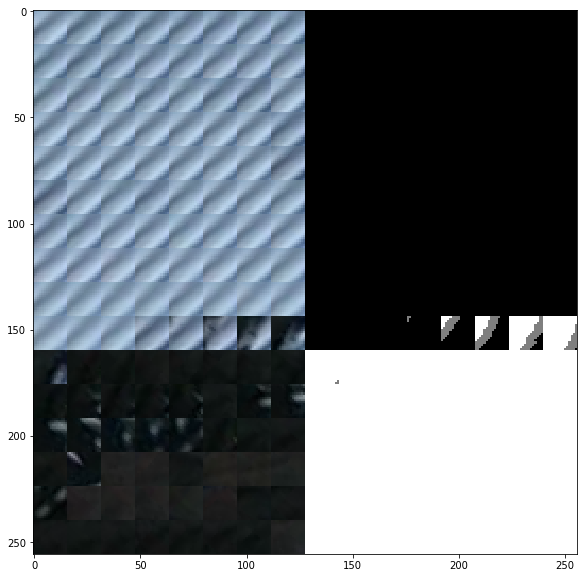

In [5]:

for x,y in data_generator(gmm_loader,1,epoch_size=1):
    print x.shape
    draw_sample(x,y,8,16)
    break

In [6]:
import theano

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/usr/local/lib/python2.7/dist-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/usr/local/lib/python2.7/dist-packages/theano/gpuarray/__init__.py", line 60, in init_dev
    sched=config.gpuarray.sched)
  File "pygpu/gpuarray.pyx", line 614, in pygpu.gpuarray.init (pygpu/gpuarray.c:9415)
  File "pygpu/gpuarray.pyx", line 566, in pygpu.gpuarray.pygpu_init (pygpu/gpuarray.c:9106)
  File "pygpu/gpuarray.pyx", line 1021, in pygpu.gpuarray.GpuContext.__cinit__ (pygpu/gpuarray.c:13468)
GpuArrayException: Unknown device error: -1


In [7]:
from sklearn import mixture

class GMMGradOp(theano.Op):
    def __init__(self, gaussLLHistModel):
        super(GMMGradOp, self).__init__()
        self.gaussLLHistModel = gaussLLHistModel
        self.otypes = [T.fmatrix,T.fvector]
        self.itypes = [T.fmatrix,T.fvector]
        
    def split(self,X,Y):
        p = X[Y < 0.1]
        n = X[Y > 0.9]
        num = self.gaussLLHistModel.sample_num
        return p[:-num],p[-num:],n[:num]
    
    def merge(self, x,yp,yn,Y):
        out = np.zeros((len(Y),x.shape[1]),dtype=np.float32)
        num = self.gaussLLHistModel.sample_num
        out[Y>0.9][:num] = yn
        out[Y <0.1]= np.concatenate((x,yp),axis=0)
        return out
        

    def perform(self, node, (X,Y), output_storage):
        x,yp,yn = self.split(X,Y)
        dX,dY = output_storage[0],output_storage[1]
        fdx,fdyp,fdyn = self.gaussLLHistModel.backward(x,yp,yn)
        dY[0] = np.zeros_like(Y,dtype=np.float32)
        dX[0] = self.merge(fdx,fdyp,fdyn,Y)
        

class GMMOp2(theano.Op):
    def __init__(self, gaussLLHistModel):
        super(GMMOp2, self).__init__()
        self.gaussLLHistModel = gaussLLHistModel
        self.otypes = [T.scalar]
        self.itypes = [T.fmatrix,T.fvector]

    def split(self,X,Y):
        p = X[Y < 0.1]
        n = X[Y > 0.9]
        num = self.gaussLLHistModel.sample_num
        return p[:-num],p[-num:],n[:num]
    
    def perform(self, node, (X,Y), output_storage):
        z = output_storage[0]        
        x,yp,yn = self.split(X,Y)
        z[0] = self.gaussLLHistModel.forward(x,yp,yn).astype(np.float32)
        
    def grad(self, (X,Y), output_grads):
        return GMMGradOp(self.gaussLLHistModel)(X,Y)

    
class GMMGetParamsOp(theano.Op):
    def __init__(self,gmm):
        super(GMMGetParamsOp, self).__init__()
        self.otypes = [T.fmatrix,T.fmatrix,T.fvector]
        self.itypes = [T.fscalar]
        self.gmm = gmm
        
    def perform(self, node, (val), output_storage):
        m,c,w = output_storage[0],output_storage[1],output_storage[2]
        c[0] = self.gmm.cov.reshape((self.gmm.gm_num,-1)).astype(np.float32)
        m[0] = self.gmm.mean.reshape((self.gmm.gm_num,-1)).astype(np.float32)
        w[0] = self.gmm.weights.astype(np.float32)

In [10]:
import theano.tensor as T
import lasagne
from lasagne import layers as L
from broadcast import BroadcastLayer,UnbroadcastLayer
from lasagne.nonlinearities import rectify
from lasagne.init import HeNormal,Constant

In [14]:
from symbols import make_conv,BroadcastLayer,res_unit

def gen_unet1(data,num_filters,deep,name='unet',first=True):    
    name = name+str(deep)
    res1 = make_conv(data,num_filters,3,name=name+'_in')   
    
    if(deep == 1):
        return res1
    
    res2 = L.Pool2DLayer(res1,2,name=name+'_pool')
    res2 = gen_unet1(res2,num_filters*2,deep-1,name[:-1],False)
    res2 = L.Deconv2DLayer(res2,num_filters*((2**(deep-1))-1),2,2,crop='valid',nonlinearity=None,name=name+'_deconv')
    res2 = L.BatchNormLayer(res2,name=name+'_deconv_bn')
    res2 = L.NonlinearityLayer(res2,rectify,name=name+'_deconv_rectify')
    res = L.ConcatLayer([res2,res1],axis=1, cropping=(None, None, "center", "center"),name=name+'_concat')
    if(first ):
        res = L.Conv2DLayer(res,num_filters*(2**(deep-1)),3,nonlinearity=None,name=name+'_conv',pad='same')
    else:
        res = make_conv(res,num_filters*(2**(deep-1)),3,name=name+'_out')   
    return res


def make_net(input_tensor):
    data_l = L.InputLayer((cfg.SEQ_LENGTH,3,cfg.TILE_SIZE[1],cfg.TILE_SIZE[0])
                           ,input_tensor
                           ,name='data')
    unet = gen_unet1(data_l,6,3,name='unet')
    return unet
    

In [15]:
from utils import get_network_str,save_weights,load_weights

data = T.tensor4(name='data')
net = make_net(data)
print get_network_str(net,incomings=True,outgoings=True)


In -->     Layer    --> Out    Description                          
-------    -----    -------    -----------                          
[]         0        [1]        data(128, 3, 32, 32)                 
[0]        1        [2]        unet3_in_conv(3)(128, 6, 32, 32)     
[1]        2        [3]        unet3_in_bn(128, 6, 32, 32)          
[2]        3        [4, 22]    unet3_in_relu(128, 6, 32, 32)        
[3]        4        [5]        unet3_pool(128, 6, 16, 16)           
[4]        5        [6]        unet2_in_conv(3)(128, 12, 16, 16)    
[5]        6        [7]        unet2_in_bn(128, 12, 16, 16)         
[6]        7        [8, 15]    unet2_in_relu(128, 12, 16, 16)       
[7]        8        [9]        unet2_pool(128, 12, 8, 8)            
[8]        9        [10]       unet1_in_conv(3)(128, 24, 8, 8)      
[9]        10       [11]       unet1_in_bn(128, 24, 8, 8)           
[10]       11       [12]       unet1_in_relu(128, 24, 8, 8)         
[11]       12       [13]       un

In [16]:
import warnings
warnings.filterwarnings('ignore')
from gauss_ll_hist import GaussLLHistModel
gmm = GaussLLHistModel(cfg.SEQ_LENGTH//4*cfg.OUT_SIZE[0]*cfg.OUT_SIZE[1],2,100)

In [17]:
from theano_utils import *

In [18]:
from lasagne.regularization import regularize_network_params,l2


params = lasagne.layers.get_all_params(net, trainable=True)
l2_loss = 1e-4 * regularize_network_params(net, l2)



label = T.tensor3(name='label')
Y = label.flatten()

X = lasagne.layers.get_output(net)
X = X[:,:,(cfg.TILE_SIZE[1]-cfg.OUT_SIZE[1])//2:(cfg.TILE_SIZE[1]-cfg.OUT_SIZE[1])//2+cfg.OUT_SIZE[1],\
          (cfg.TILE_SIZE[0]-cfg.OUT_SIZE[0])//2:(cfg.TILE_SIZE[0]-cfg.OUT_SIZE[0])//2+cfg.OUT_SIZE[0]]
X = T.transpose(X,(0,2,3,1)).reshape((cfg.SEQ_LENGTH*cfg.OUT_SIZE[0]*cfg.OUT_SIZE[1],-1))
X = X/T.sqrt(T.square(X).sum(1)[:,None])


G_lr = theano.shared(np.array(0.001, dtype=theano.config.floatX))



outX,outYp,outYn = split(X,Y,int(cfg.SEQ_LENGTH*cfg.OUT_SIZE[0]*cfg.OUT_SIZE[1]*0.1))

loss = l2_loss+GMMOp2(gmm)(X,Y)#center_loss(X,Y)
mean,covars,weihgts = GMMGetParamsOp(gmm)(loss)
# mean = T.mean(outX,axis=0).reshape((1,-1))
# covars = (T.std(outX,axis=0)+0.0001).reshape((1,-1))
# weihgts = None
p_p = calc_log_prob_gauss_vector(outYp,mean,covars,weihgts)
p_n = calc_log_prob_gauss_vector(outYn,mean,covars,weihgts)
#loss = histogram_loss(p_n,p_p,0.0001,200)[0]


MAX_GRAD_NORM = 15
all_grads = T.grad(loss, params)
all_grads = [T.clip(g, -.1, .1) for g in all_grads]
all_grads, norm = lasagne.updates.total_norm_constraint(all_grads, MAX_GRAD_NORM, return_norm=True)
updates = lasagne.updates.adam(all_grads,params,G_lr)


In [20]:
#train_fn = theano.function([data, label], [loss,X], allow_input_downcast=True, updates=updates)
train_fn = theano.function([data, label], [loss,p_p,p_n], allow_input_downcast=True, updates=updates)
print 'train_fn compiled'

train_fn compiled


In [21]:
# acc_r = [1000]
# accyracy = GMMAccuracyOp(acc_r)(X,Y)
test_fn  = theano.function([data, label],[p_p,p_n], allow_input_downcast=True)
print 'test_fn compiled'

test_fn compiled


In [22]:
def accuracy(yp,yn,rate):
    return float((yp>rate).sum()+(yn<rate).sum())/float(len(yp)+len(yn))

In [23]:
G_lr.set_value(np.float32(0.001))

In [24]:
load_weights(net,'models/gmm099_loss1137.18')#models/gmm000_loss17428.31

In [25]:
hard = []
cur = 0

In [23]:


for j in range(0,100):
    train_loss=0
    train_acc=0
    for i,batch in enumerate(data_generator(gmm_loader,epoch_size=100)):
        res = train_fn(*batch)
        train_acc += accuracy(res[1],res[2],60)
        train_loss+=res[0]
        if(res[0] > 1):
            if( len(hard) < 1000):
                hard.append(batch)
            else:
                hard[cur] = batch
                cur = (cur+1) % len(hard)
        for k in range(min(10,len(hard))):
            batch = hard[np.random.randint(0,len(hard))]
            res = train_fn(*batch)
        print '\r epoch %i batch %i loss=%.2f ,acc=%.2f %.2f'%(j,i,train_loss/float(i+1),train_acc/float(i+1),res[0]),
    print ''
    save_weights(net,'models/%s%03i_loss%05.2f'%\
                 (cfg.NAME,j,train_loss/float(i+1)))
    if(j == 50):
        G_lr.set_value(np.float32(0.0001))
    print ''
#     for i,batch in enumerate(data_generator(gmm_loader,epoch_size=10)):
#         res = test_fn(*batch)
#         train_acc+=res[0]
#     print 'accuracy ',train_acc/10

 epoch 0 batch 4 loss=123573.84 ,acc=0.50 0.00 

KeyboardInterrupt: 

# Draw Histogram

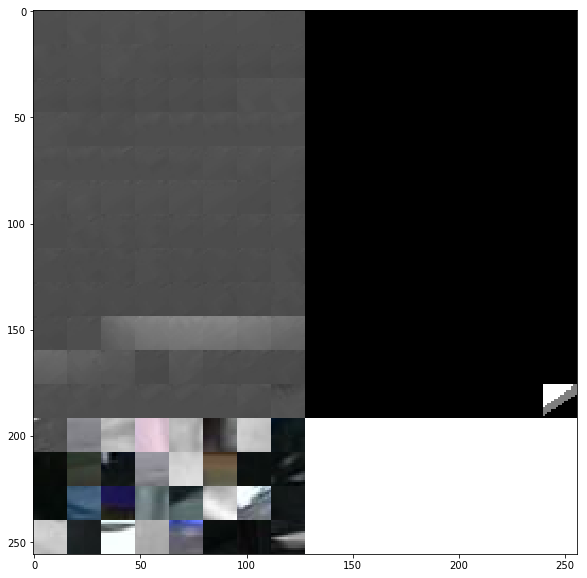

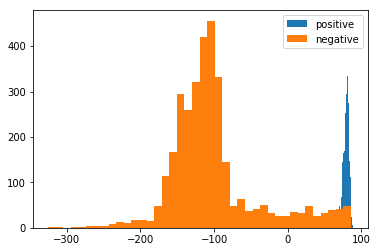

In [27]:
for i,batch in enumerate(data_generator(gmm_loader,epoch_size=10)):
    #batch = hard[10]
    draw_sample(batch[0],batch[1],8,16)
    res = test_fn(*batch)
    plt.hist(res[0],bins=40,label='positive')
    plt.hist(res[1],bins=40,label='negative')
    plt.legend()
    plt.show()
    break

In [83]:
test_acc = 0
for i,batch in enumerate(data_generator(gmm_loader,epoch_size=100)):
    res = test_fn(*batch)
    test_acc += accuracy(res[0],res[1],50)
    print '\r', (test_acc/(i+1)),

0.995500610501                                                        
